In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import seaborn as sns

In [13]:
geo_df = gpd.read_file("NUTS_RG_20M_2024_4326.geojson")
geo_df_italy = geo_df[geo_df["CNTR_CODE"] == "IT"]
geo_df_belgium = geo_df[geo_df["CNTR_CODE"] == "BE"]

nuts_3_italy = list(geo_df_italy["NUTS_NAME"])[:107]
nuts_3_belgium = list(geo_df_belgium["NUTS_NAME"])[:44]

In [16]:
data_italy = {"CO" : pd.read_csv("Italia_co_daily_all.csv", index_col=0).loc[nuts_3_italy],
              "NO2" : pd.read_csv("Italia_no2_daily_all.csv", index_col=0).loc[nuts_3_italy],
              "SO2" : pd.read_csv("Italia_so2_daily_all.csv", index_col=0).loc[nuts_3_italy],
              "PM10" : pd.read_csv("Italia_pm10_daily_all.csv", index_col=0).loc[nuts_3_italy],
              "PM2.5" : pd.read_csv("Italia_pm25_daily_all.csv", index_col=0).loc[nuts_3_italy],
             }
data_belgium = {"CO" : pd.read_csv("Belgio_co_daily_all.csv", index_col=0).loc[nuts_3_belgium],
                "NO2" : pd.read_csv("Belgio_no2_daily_all.csv", index_col=0).loc[nuts_3_belgium],
                "SO2" : pd.read_csv("Belgio_so2_daily_all.csv", index_col=0).loc[nuts_3_belgium],
                "PM10" : pd.read_csv("Belgio_pm10_daily_all.csv", index_col=0).loc[nuts_3_belgium],
                "PM2.5" : pd.read_csv("Belgio_pm25_daily_all.csv", index_col=0).loc[nuts_3_belgium],
               }
data_italy = {i: data_italy[i].loc[nuts_3_italy] for i in data_italy}
data_belgium = {j:data_belgium[j].loc[nuts_3_belgium] for j in data_belgium}

In [17]:
# Merge Italy and Belgium data for each pollutant
data_total = {
    pollutant: pd.concat([data_italy[pollutant], data_belgium[pollutant]], axis=0)
    for pollutant in data_italy.keys()
}

In [18]:
limiti_UE = {"CO" : 4000,
             "NO2" : 50,
             "SO2" : 50,
             "PM10": 45,
             "PM2.5" : 25}

In [19]:
def build_indicators_table(data, limits, date_range):
    # Ensure date_range is in the correct format (DD/MM/YYYY)
    date_range_str = pd.date_range(start=date_range[0], end=date_range[1]).strftime("%d/%m/%Y").tolist()
    
    # Filter data by date_range
    data_filtered = {i: df.loc[:, df.columns.intersection(date_range_str)] for i, df in data.items()}

    # Compute indicators
    indi_tables = {i: data_filtered[i] / limits[i] for i in data_filtered}
    
    # Count days where values exceed the limit
    days_above_limit = {i: (data_filtered[i] > limits[i]).sum(axis=1) for i in data_filtered}
    
    # Compute final indicator: mean * number of days exceeding limit
    indi_table = {i: (indi_tables[i].sum(axis=1) / indi_tables[i].shape[1]) * days_above_limit[i] 
                  if indi_tables[i].shape[1] > 0 else pd.Series(0, index=indi_tables[i].index)
                  for i in indi_tables}

    # Convert dictionary to DataFrame
    df = pd.DataFrame(indi_table)

    # Replace NaNs with 0 before normalization
    df.fillna(0, inplace=True)

    # Normalize using MinMaxScaler
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

    # Compute composite indicator
    df_norm["Composite_indicator"] = df_norm.sum(axis=1)

    # Normalize composite indicator correctly
    df_norm["Composite_indicator"] = scaler.fit_transform(df_norm[["Composite_indicator"]])  # Reshape needed

    return df_norm


# Example usage
date_range = ("2024-01-01", "2024-12-31")  # Ensure date range is correctly formatted
result_df = build_indicators_table(data_total, limiti_UE, date_range)

In [20]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

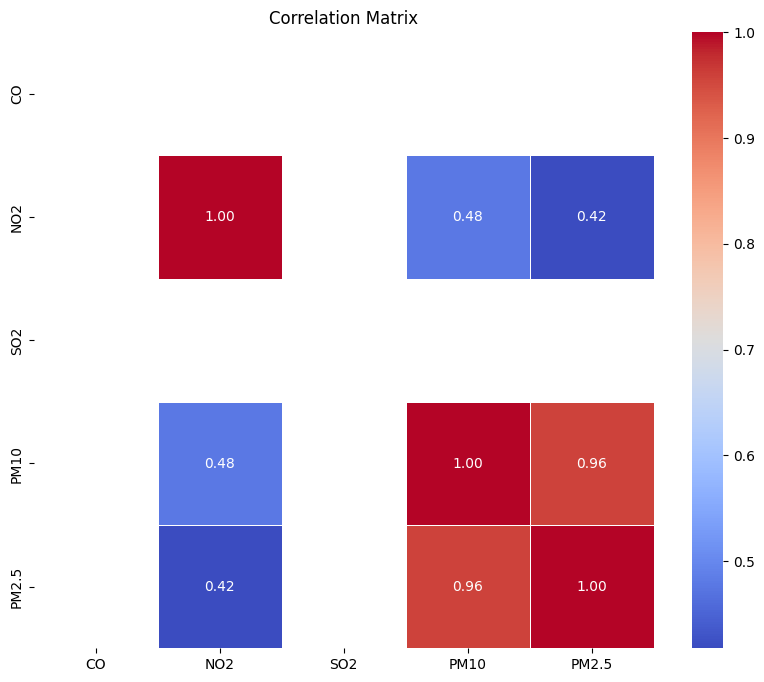

In [21]:
plot_correlation_matrix(df= result_df[["CO", "NO2", "SO2", "PM10", "PM2.5"]])

In [22]:
def cronbach_alpha(items_scores):
    items_scores = np.array(items_scores)
    item_vars = items_scores.var(axis=1, ddof=1)
    total_var = items_scores.sum(axis=0).var(ddof=1)
    n_items = items_scores.shape[0]
    alpha = (n_items / (n_items - 1)) * (1 - (item_vars.sum() / total_var))
    return alpha

In [23]:
alpha = cronbach_alpha(result_df[["CO", "NO2", "SO2", "PM10", "PM2.5"]])
print(f"Alpah di Cronbach is. {alpha}")

Alpah di Cronbach is. 0.9666614019774271


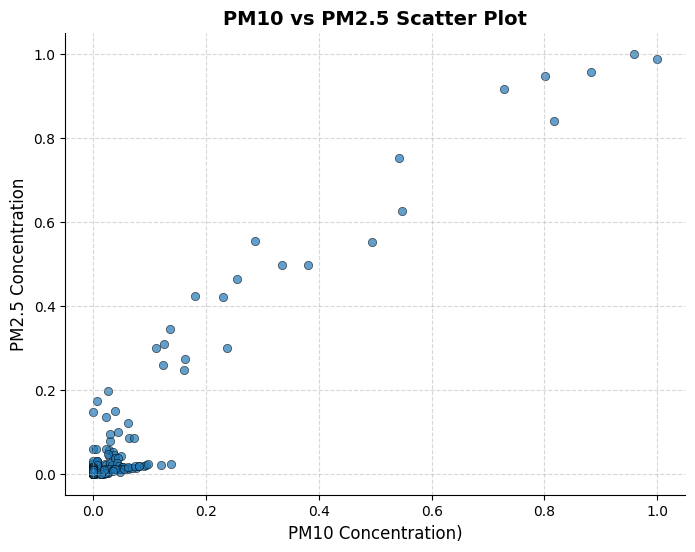

In [25]:
def plot_pm_scatter(result_df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=result_df["PM10"], y=result_df["PM2.5"], alpha=0.7, edgecolor="k")
    
    # Improve aesthetics
    plt.xlabel("PM10 Concentration)", fontsize=12)
    plt.ylabel("PM2.5 Concentration", fontsize=12)
    plt.title("PM10 vs PM2.5 Scatter Plot", fontsize=14, fontweight="bold")
    
    plt.grid(True, linestyle="--", alpha=0.5)
    sns.despine()  # Remove top and right spines for a cleaner look
    plt.show()

# Example usage
# plot_pm_scatter(result_df)
plot_pm_scatter(result_df)